<font size="6"> **ML-Factor Research** </font>

Compute the ML-(Combined)Factor and perform a proper evaluation, from a portfolio manager point of view

In [1]:
%%capture
%run 04_alphaml_feat_eng.ipynb

In [2]:
MODEL_VERSION = 'v01'
print('Model version: ', MODEL_VERSION)

Model version:  v01


In [3]:
INPATH =  "../data/" + cfg['output']['main'] + "/" + cfg['output']['alpha_factors_ml']['folder'] + "/" + MODEL_VERSION +"/"
INFILE1 = cfg['output']['alpha_factors_ml']['features']
INFILE2 = cfg['output']['alpha_factors_ml']['targets']
INFILE3 = cfg['output']['alpha_factors_ml']['model']

In [4]:
IN_FILE4 = "../data/fred_sp500.csv"

In [5]:
splits = cfg['models']['alpha_ml']['splits']
split_col = cfg['models']['alpha_ml']['split_col']

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import pickle

from mle_quant_utils import mle_utils

In [7]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 8)
sns.set_context("talk")

# Load Data

## ML-Alpha

In [8]:
features_df = pd.read_csv(INPATH + INFILE1, parse_dates=['date'])
features_df['date'] = features_df['date'].dt.tz_localize('utc')
features_df.set_index(['date', 'asset'], inplace=True)
split = features_df.pop(split_col)
features = features_df.columns.tolist()
pd.concat([features_df.head(2), features_df.tail(2)],axis=0)

Mean_Reversion_Sector_Neutral_Smoothed  \
date                      asset                                           
2013-01-03 00:00:00+00:00 A                                   -0.795709   
                          AAL                                  0.558847   
2015-12-28 00:00:00+00:00 ZION                                 0.773366   
                          ZTS                                 -0.944433   

                                 Momentum_1YR_Smoothed  \
date                      asset                          
2013-01-03 00:00:00+00:00 A                  -1.230279   
                          AAL                 1.713471   
2015-12-28 00:00:00+00:00 ZION               -0.188031   
                          ZTS                 0.209727   

                                 Overnight_Sentiment_Smoothed  adv_120d  \
date                      asset                                           
2013-01-03 00:00:00+00:00 A                         -1.301799  1.338573   
                          AAL                       -1.632765  1.139994   
2015-12-28 00:00:00+00:00 ZION                       1.325552 -0.965002   
                          ZTS                        0.441851  0.229762   

                                  adv_20d  dispersion_120d  dispersion_20d  \
date                      asset                                              
2013-01-03 00:00:00+00:00 A      1.397411         0.013270        0.011178   
                          AAL    1.081155         0.013270        0.011178   
2015-12-28 00:00:00+00:00 ZION  -0.724635         0.014916        0.014731   
                          ZTS   -0.180275         0.014916        0.014731   

                                 market_vol_120d  market_vol_20d  \
date                      asset                                    
2013-01-03 00:00:00+00:00 A             0.127654        0.135452   
                          AAL           0.127654        0.135452   
2015-12-28 00:00:00+00:00 ZION          0.183680        0.181479   
                          ZTS           0.183680        0.181479   

                                 volatility_120d  ...    sector_code_5  \
date                      asset                   ...                    
2013-01-03 00:00:00+00:00 A            -0.836546  ...                0   
                          AAL           1.639924  ...                0   
2015-12-28 00:00:00+00:00 ZION          0.547895  ...                1   
                          ZTS           0.413572  ...                0   

                                 sector_code_6  sector_code_7  sector_code_8  \
date                      asset                                                
2013-01-03 00:00:00+00:00 A                  0              0              0   
                          AAL                0              0              0   
2015-12-28 00:00:00+00:00 ZION               0              0              0   
                          ZTS                0              0              0   

                                 sector_code_9  sector_code_10  qtr_1  qtr_2  \
date                      asset                                                
2013-01-03 00:00:00+00:00 A                  0               0      1      0   
                          AAL                0               0      1      0   
2015-12-28 00:00:00+00:00 ZION               0               0      0      0   
                          ZTS                0               0      0      0   

                                 qtr_3  qtr_4  
date                      asset                
2013-01-03 00:00:00+00:00 A          0      0  
                          AAL        0      0  
2015-12-28 00:00:00+00:00 ZION       0      1  
                          ZTS        0      1  

[4 rows x 33 columns]

In [9]:
valid_dates = split[split=='valid'].index.get_level_values(0)
valid_start = valid_dates[0].strftime('%Y-%m')
valid_end = valid_dates[-1].strftime('%Y-%m')

In [10]:
test_dates = split[split=='test'].index.get_level_values(0)
test_start = test_dates[0].strftime('%Y-%m')
test_end = test_dates[-1].strftime('%Y-%m')

In [11]:
targets_df = pd.read_csv(INPATH + INFILE2, parse_dates=['date'])
targets_df['date'] = targets_df['date'].dt.tz_localize('utc')
targets_df.set_index(['date', 'asset'], inplace=True)
pd.concat([targets_df.head(2), targets_df.tail(2)],axis=0)

return_5d_raw  target
date                      asset                       
2013-01-03 00:00:00+00:00 A           0.013820     0.0
                          AAL         0.056681     1.0
2015-12-28 00:00:00+00:00 ZION        0.040065     0.0
                          ZTS         0.032838     0.0

In [12]:
with open(INPATH + INFILE3, 'rb') as file:
    model = pickle.load(file)

## External Data

In [13]:
sp500 = pd.read_csv(IN_FILE4, parse_dates=['DATE'], index_col='DATE')
sp500_close = sp500.loc['2013':'2016', 'sp500_close'].dropna().copy()

## Data Partition

In [14]:
X_train, X_valid, X_test, y_train, y_valid, y_test = mle_utils.train_valid_test_split(
    all_factors[features], targets_df[target_col],  splits['train'], splits['valid'], splits['test'])


# Alpha Factor Evaluation

In [15]:
all_assets = all_factors.index.levels[1].values.tolist()
all_pricing = quant_helper.get_pricing(
    data_portal,
    trading_calendar,
    all_assets,
    factor_start_date,
    universe_end_date)

C:\Users\manua\Documents\repos\dslab_ai4trading\alpha_factors\mle_quant_utils\quant_helper.py:54: FutureWarning: offset is deprecated. Use freq instead
  end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
C:\Users\manua\Documents\repos\dslab_ai4trading\alpha_factors\mle_quant_utils\quant_helper.py:55: FutureWarning: offset is deprecated. Use freq instead
  start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')


In [16]:
factor_names = ['Momentum_1YR_Smoothed',
                'Mean_Reversion_Sector_Neutral_Smoothed','Overnight_Sentiment_Smoothed']

In [17]:
train_ml_alpha, train_factor_returns, train_sharpe_ratio, train_factor_cum_rets, train_factor_fra = quant_factors.mlfactor_evaluation(
    all_factors, X_train, model, factor_names, all_pricing, quantiles=None, bins=5, periods = 5)

Cleaning Data...

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------



In [18]:
valid_ml_alpha, valid_factor_returns, valid_sharpe_ratio, valid_factor_cum_rets, valid_factor_fra = quant_factors.mlfactor_evaluation(
    all_factors, X_valid, model, factor_names, all_pricing, quantiles=None, bins=5, periods = 5)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------



In [19]:
test_ml_alpha, test_factor_returns, test_sharpe_ratio, test_factor_cum_rets, test_factor_fra = quant_factors.mlfactor_evaluation(
    all_factors, X_test, model, factor_names, all_pricing, quantiles=None, bins=5, periods = 5)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------



## Sharpe Ratio

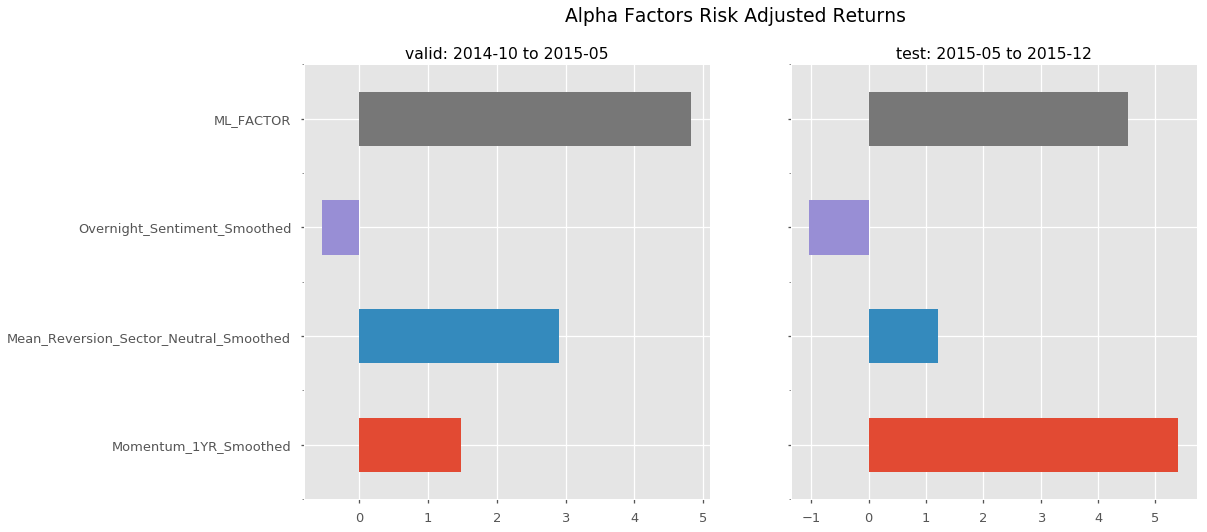

In [20]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16,8))
ax1, ax2 = axs

valid_sharpe_ratio.plot.barh(ax=ax1)
ax1.set_title('valid: {} to {}'.format(valid_start, valid_end))
test_sharpe_ratio.plot.barh(ax=ax2)
ax2.set_title('test: {} to {}'.format(test_start, test_end))
plt.suptitle("Alpha Factors Risk Adjusted Returns")
plt.show()

## Cummulative Factor (Weighted) Returns

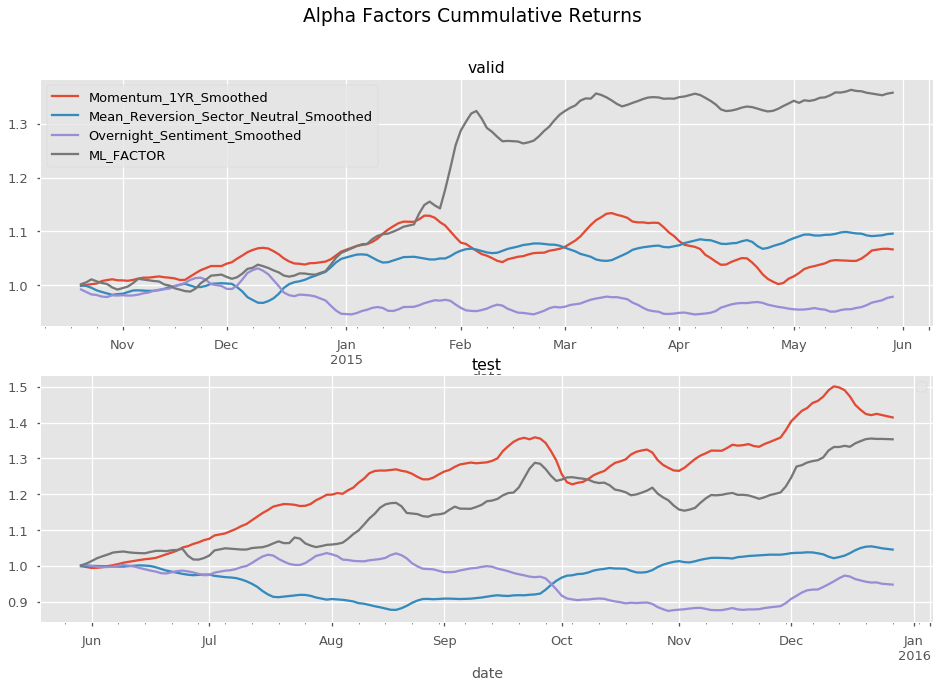

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(16,10))
ax1, ax2 = axs

valid_factor_cum_rets.plot(ax=ax1)
ax1.set_title('valid')
test_factor_cum_rets.plot(ax=ax2)
ax2.set_title('test')
ax2.legend("")
plt.suptitle("Alpha Factors Cummulative Returns")
plt.show()

## Turnover Analysis: Factor Ranked Autocorrelation (FRA)

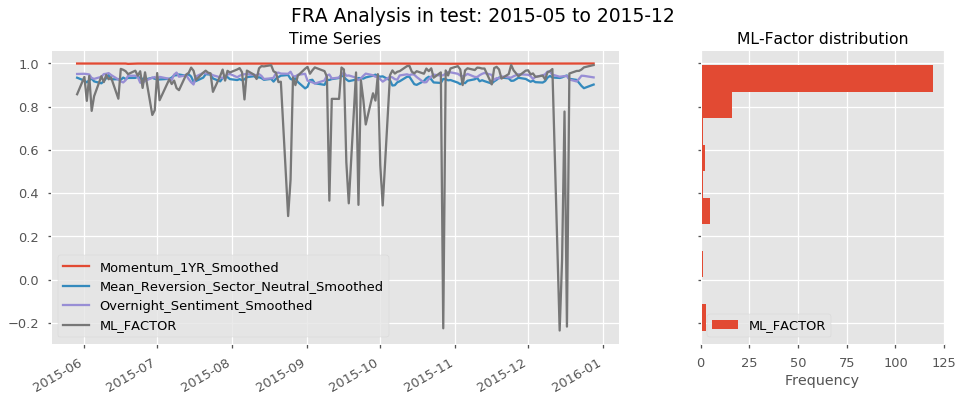

In [23]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16,6), gridspec_kw={'width_ratios': [0.7, 0.3]})
ax1, ax2 = axs

plt.suptitle('FRA Analysis in test: {} to {}'.format(test_start, test_end))
test_factor_fra.plot(ax=ax1)
ax1.set_title('Time Series')

test_factor_fra['ML_FACTOR'].plot.hist(ax=ax2, orientation='horizontal')
ax2.set_title('ML-Factor distribution')
ax2.legend()


plt.show()

FRA reveals that there are sudden changes in alhpa factor yielded by this factor, this means that alpha vector changes from a day to other, leading to high transaction costs. This may be improved in two ways:
* A better model that captures more smoothly the ground truth (a smoother distribution of predicted probability)
* Apply a risk model in a portfolio optimization exercise that regularizes turnover

## Direction Accuracy Analysis

In [24]:
targets_df['preds'] = model.predict(features_df)
targets_df['flg_correct'] = targets_df[target_col] == targets_df['preds']
avg_daily_acc = targets_df.groupby(level=0)['flg_correct'].mean()

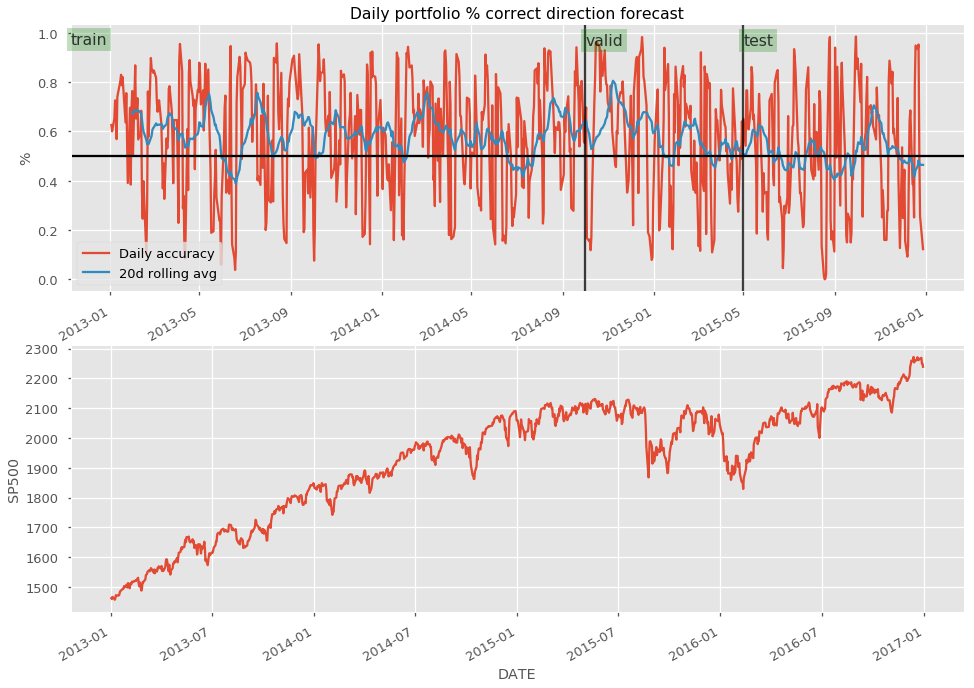

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(16,12))
ax1, ax2 = axs


avg_daily_acc.plot(ax=ax1, label='Daily accuracy')
avg_daily_acc.rolling(20).mean().plot(ax=ax1, label='20d rolling avg')
ax1.axhline(y=0.5, color='black')

ax1.text(0, 0.925, 'train', alpha=0.75, transform = ax1.transAxes, bbox=dict(facecolor='green', alpha=0.25))
ax1.axvline(x=valid_start, color='black', alpha=0.75)

ax1.text(valid_start, 0.95, 'valid', alpha=0.75, bbox=dict(facecolor='green', alpha=0.25))
ax1.axvline(x=test_start, color='black', alpha=0.75)

ax1.text(test_start, 0.95, 'test',  alpha=0.75, bbox=dict(facecolor='green', alpha=0.25))
ax1.set_title('Daily portfolio % correct direction forecast')

ax1.set_ylabel('%')
ax1.legend(loc='lower left')

sp500_close.plot(y='sp500_close', ax=ax2)
ax2.set_ylabel('SP500')
plt.show()

In [26]:
avg_daily_acc[:5]

date
2013-01-03 00:00:00+00:00    0.626327
2013-01-04 00:00:00+00:00    0.600849
2013-01-07 00:00:00+00:00    0.651805
2013-01-08 00:00:00+00:00    0.726115
2013-01-09 00:00:00+00:00    0.723992
Name: flg_correct, dtype: float64

As an overal assessemnt, it is displayed how many stocks from the universe does the model correctly forecast their direction, that 's it, daily directional accuracy.

For example, given the following table, on 2013-01-03, 62% of the stocks direction in working universe, 295 are correctly forecasted, and 176 wrongly. However, remember what was previously said, that model is skewed to positive target prediction; in order to build a good forecasting model, some useful features must be discarded  